In [17]:
%load_ext autoreload
%autoreload 2

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn            import preprocessing 
from sklearn.metrics    import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from sklearn.neighbors  import KNeighborsRegressor

from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.base                import ForecastingHorizon

In [19]:
import sys,os
sys.path.append("../data")

from getNewestData import resample_fix_ends, reassign_outliers

In [20]:
pdf = pd.read_csv("../data/monthly/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)
pdf.index = pd.to_datetime(pdf['Timestamp'],utc=True)
pdf.index = pdf.index.tz_localize(None)  

pdf["y"] = pdf["NE7_GWh"].values
pdf = pdf.drop(columns=["Timestamp","NE5_GWh","NE7_GWh"])

#split data in train val and test
#2657/365/(days since first december last year) 
include_validation = False

if include_validation:
    n_test = (pdf.index[-1] -pd.to_datetime("2022-11-30")).days
    split = len(pdf)-365-n_test
    pdf_train, pdf_val, pdf_test = pdf.iloc[:split], pdf.iloc[split:split+365], pdf.iloc[split+365:]

else: 
    split = len(pdf)-12
    pdf_train, pdf_test = pdf.iloc[:split], pdf.iloc[split:]

In [21]:
idx = pd.period_range(start=pdf_train.index[0], end= pdf_train.index[-1], freq="M")
y = pd.Series(pdf_train.y.values, index=idx)
y

2015-01    172.482558
2015-02    157.543740
2015-03    165.323134
2015-04    148.718442
2015-05    150.259261
              ...    
2022-03    154.503365
2022-04    139.388619
2022-05    141.681254
2022-06    139.280821
2022-07    140.266726
Freq: M, Length: 91, dtype: float64

In [22]:
forecaster = Prophet(  
    seasonality_mode='additive',
    add_country_holidays={'country_name': 'Switzerland'},
    yearly_seasonality=True)

idx = pd.period_range(start=pdf_train.index[0], end= pdf_train.index[-1], freq="M")
y_train = pd.Series(pdf_train.y.values, index=idx)

forecaster.fit(y)


15:05:08 - cmdstanpy - INFO - Chain [1] start processing
15:05:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet(add_country_holidays={'country_name': 'Switzerland'}, n_changepoints=1,
        yearly_seasonality=True)

In [23]:
idx = pd.period_range(start=pdf_test.index[0], end= pdf_test.index[-1], freq="M")
horizon = ForecastingHorizon(idx, is_relative=False)
y_pred  = forecaster.predict(fh=horizon)

In [24]:
idx = pd.period_range(start=pdf_train.index[0], end= pdf_train.index[-1], freq="M")
horizon = ForecastingHorizon(idx, is_relative=False)

fit  = forecaster.predict(fh=horizon)

In [25]:
idx = pd.period_range(start=pdf_test.index[0], periods=60, freq="M")
horizon = ForecastingHorizon(idx, is_relative=False)

five_years  = forecaster.predict(fh=horizon)

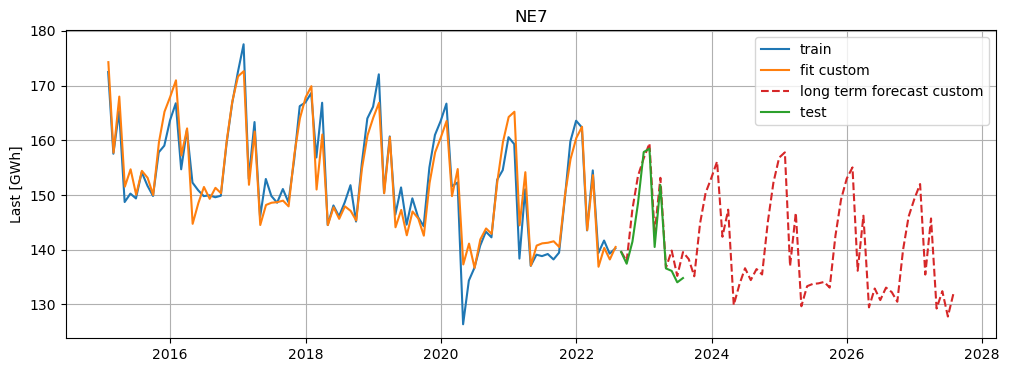

In [26]:
f, axes = plt.subplots(1, 1, figsize=(12, 4))

axes.plot(pdf_train, color="tab:blue", label="train")
axes.plot(fit.index.to_timestamp(how="end"), fit.values, color="tab:orange", label="fit custom")
#axes.plot(y_pred.index.to_timestamp(how="end"), y_pred.values, color="tab:red", label="forecast custom")
axes.plot(five_years.index, five_years.values, color="tab:red", linestyle="--",label="long term forecast custom")
axes.plot(pdf_test, color="tab:green", label="test ")
axes.legend()
axes.set_title("NE7")
axes.set_ylabel("Last [GWh]")
axes.grid()
plt.show()

In [27]:
print(f"RMSE: {mean_squared_error(y_pred.values, pdf_test.values, squared=False)}")
print(f'MAE:  {mean_absolute_error(y_pred.values, pdf_test.values.flatten())}')
print(f'MAPE: {mean_absolute_percentage_error(y_pred.values, pdf_test.values.flatten())}')

# sklearn mape is not multiplied by 100

RMSE: 3.0014826094285496
MAE:  2.255454352227685
MAPE: 0.015472773481700114
